In [ ]:
!pip install qiskit
!pip install qiskit_aer

In [2]:
!pip install seaborn
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 829.5 kB/s eta 0:00:13
   -- ------------------------------------- 0.8/11.0 MB 829.6 kB/s eta 0:00:13
   -- ------------------------------------- 0.8/11.0 MB 829.6 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/11.0 MB 801.6 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/11.0 MB 801.6 kB/s eta 0:00:13
   ---- ----------------------------------- 1.3/11.0 MB 731.5 kB/s eta 0:00:14
   ---- ----------------------------------- 1.3/11.0 MB 731.5 kB/s eta 0:00:14
   ---- ----------------------------------- 1.3/11.0 MB 731.5 kB/s eta 0:00:14
   ---- ----------------------------------- 1.3/11.0 MB 731.5 kB/s eta 0:00:14
 

In [3]:
import numpy as np
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
#The Simulation Function
def simulation(Hx, Hz, decoder_fn, p, N_trials, max_iter):
    logical_failures = 0

    for _ in range(N_trials):
        initial_bitstring = "0" * Hx.shape[1]

        noisy_x_str = custom_noise_channel(p, initial_bitstring) #Pass through depolarizing noise
        noisy_z_str = custom_noise_channel(p, initial_bitstring)

        e_x = np.array([int(bit) for bit in noisy_x_str])
        e_z = np.array([int(bit) for bit in noisy_z_str])

        s_x = (Hx @ e_x) % 2
        s_z = (Hz @ e_z) % 2

        c_hat_x = decoder_fn(e=0.1, max_iter = max_iter, bitstring=e_x, H=Hx) #Decode errors
        c_hat_z = decoder_fn(e=0.1, max_iter = max_iter, bitstring=e_z, H=Hz)

        res_x = (e_x + c_hat_x) % 2  #Residual errors
        res_z = (e_z + c_hat_z) % 2

        valid_x = np.all((Hx @ res_x) % 2 == 0)
        valid_z = np.all((Hz @ res_z) % 2 == 0)

        if not (valid_x and valid_z):
            logical_failures += 1

    return logical_failures / N_trials


In [13]:
#The decoder function
def decoder(e, max_iter, bitstring, H):
    eps = 1e-10
    e = max(min(e, 1 - eps), eps)

    H = np.array(H)

    R = []     #Calculate initial LLRs (R)
    for i in bitstring:
        i = int(i)
        if i == 1:
            r = np.log(e / (1 - e))
        elif i == 0:
            r = np.log((1 - e) / e)
        else:
            raise ValueError("Bitstring must contain only 0s and 1s")
        R.append(r)

    R = np.array(R)

    M = np.zeros_like(H, dtype=float) #Initialize messages
    E = np.zeros_like(H, dtype=float)

    for _ in range(max_iter):
        for i in range(H.shape[0]):  #Variable-to-check messages
            for j in range(H.shape[1]):
                if H[i, j] == 1:
                    M[i, j] = R[j]

        for i in range(H.shape[0]):#Check-to-variable messages
            for j in range(H.shape[1]):
                if H[i, j] == 1:
                    prod = 1.0
                    for k in range(H.shape[0]):
                        if H[k, j] == 1 and k != i:
                            prod *= np.tanh(M[k, j]/2)

                    numerator = max(1 + prod, eps)
                    denominator = max(1 - prod, eps)
                    E[i, j] = np.log(numerator / denominator)

        L = np.zeros(H.shape[1])#Belief update and hard decision
        C = np.zeros(H.shape[1])

        for j in range(H.shape[1]):
            L[j] = R[j]
            for i in range(H.shape[0]):
                if H[i, j] == 1:
                    L[j] += E[i, j]
            C[j] = 0 if L[j] >= 0 else 1

        # Step 5: Check if all parity checks are satisfied
        if np.all((H @ C) % 2 == 0):
            break

    return C


In [14]:
def custom_noise_channel(p_error, initial_bitstring):
    n_qubits = len(initial_bitstring)
    qc = QuantumCircuit(n_qubits, n_qubits)

    # Set the initial state from bitstring
    for i, bit in enumerate(initial_bitstring):
        if bit == '1':
            qc.x(i)

    # Define Kraus operators for full depolarizing channel
    I = np.eye(2)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    k0 = np.sqrt(1 - p_error) * I
    k1 = np.sqrt(p_error / 3) * X
    k2 = np.sqrt(p_error / 3) * Y
    k3 = np.sqrt(p_error / 3) * Z

    depolarizing_channel = Kraus([k0, k1, k2, k3])

    # Define noise model
    noise_model = NoiseModel()
    for qubit in range(n_qubits):
        noise_model.add_quantum_error(depolarizing_channel, ['id'], [qubit])
        qc.id(qubit)  # Apply identity so the noise attaches here

    # Measure all qubits
    qc.measure(range(n_qubits), range(n_qubits))

    # Simulate
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts()
    noisy_bitstring = list(counts.keys())[0]

    return noisy_bitstring

In [18]:
def plot_logical_error_rate(Hx, Hz, decoder_fn, max_iter, N_trials=500, p_range=None):
    if p_range is None:
        p_range = np.linspace(0.01, 1.0, 20)

    logical_error_rates = []

    for p in p_range:
        print(f"Simulating for p = {p:.3f}")
        ler = simulation(Hx, Hz, decoder_fn, p, N_trials, max_iter)
        logical_error_rates.append(ler)

    # Plotting with Seaborn
    sns.set(style="whitegrid", context="talk", font_scale=0.5)
    palette = sns.color_palette("deep")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=p_range, y=logical_error_rates, marker='o', linewidth=2.5, color=palette[0])
    plt.title(f"LER vs PER for {max_iter} iterations")
    plt.xlabel("Physical Error Rate (p)")
    plt.ylabel("Logical Error Rate (LER)")
    plt.yscale("log")
    plt.xticks(np.round(p_range, 3))
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [8]:
#Example
#Here the HX and HZ are collected from the hypergraph product code of the 3- bit repetition code
HX = np.matrix([[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
HZ = np.matrix([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]])


Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


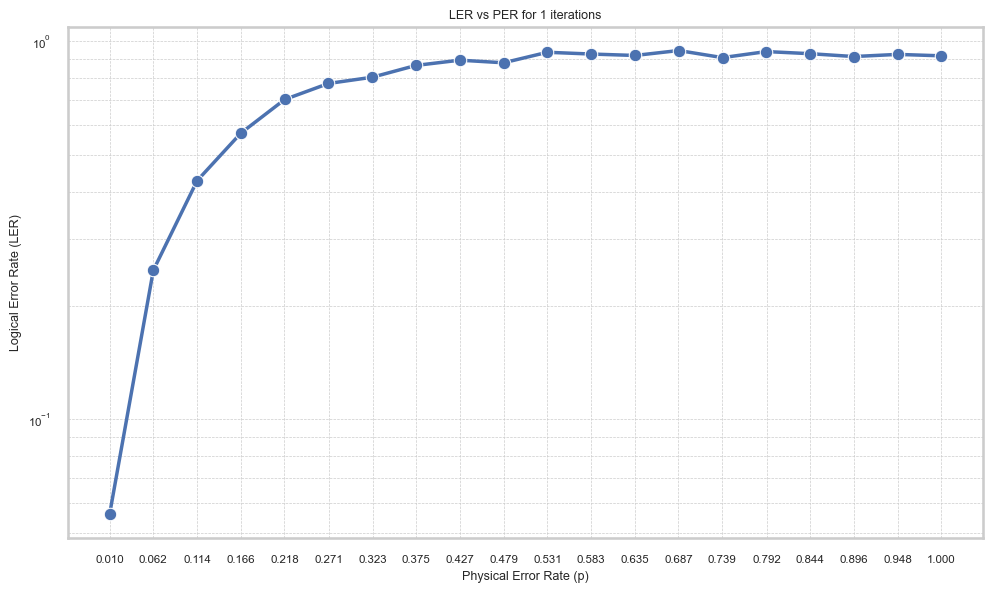

In [19]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=1,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


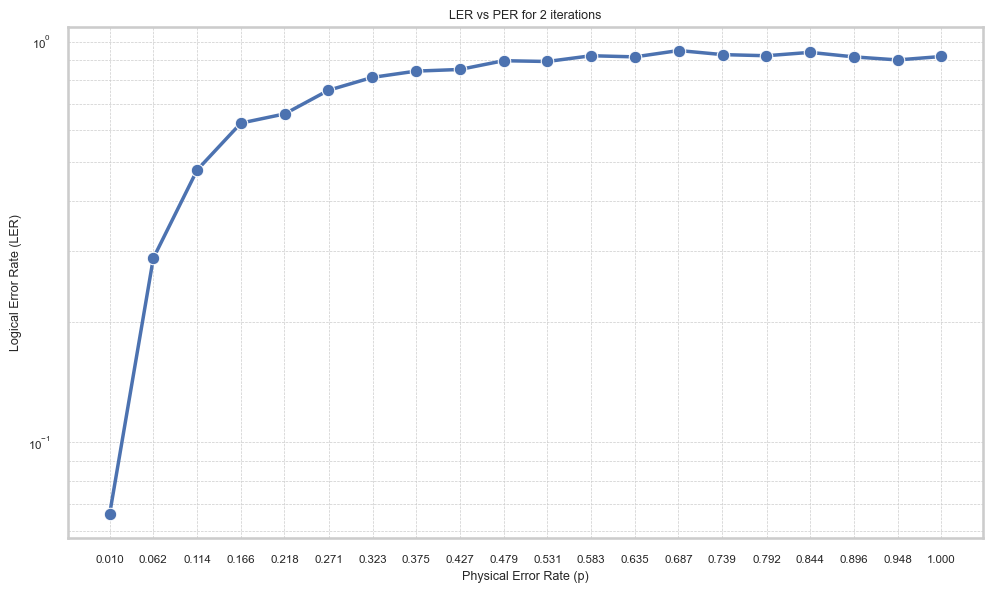

In [20]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=2,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


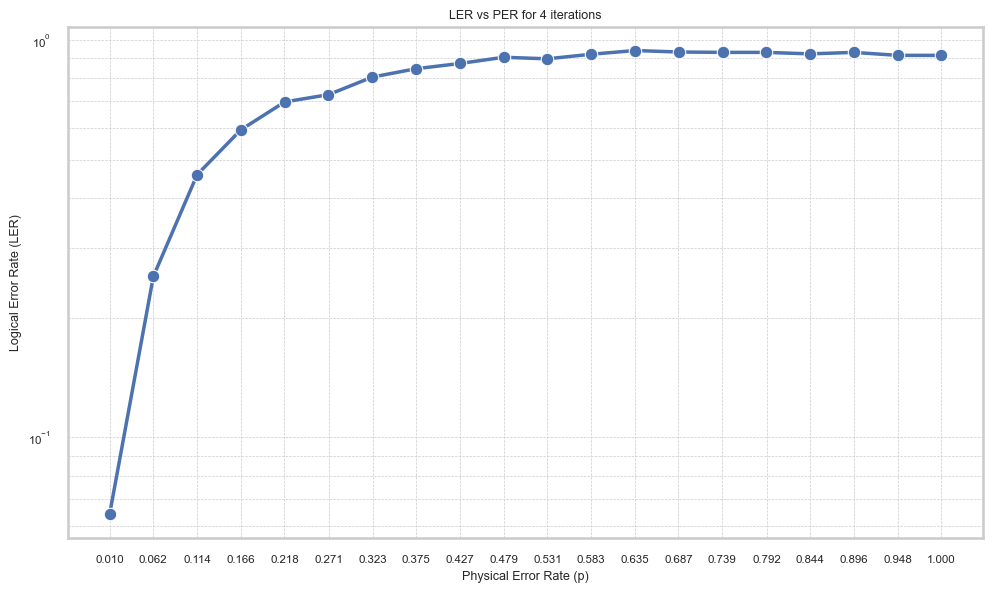

In [21]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=4,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


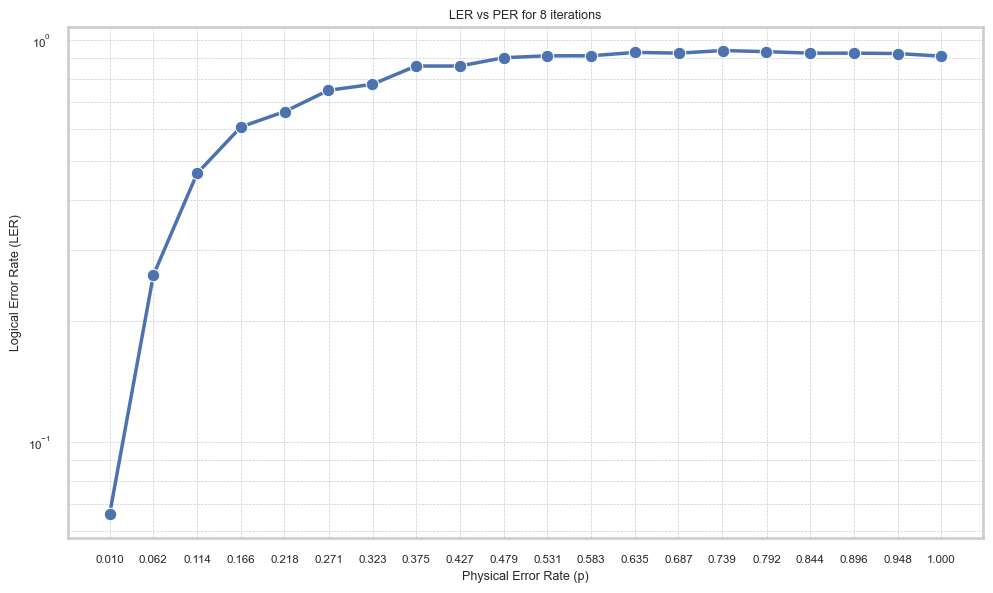

In [22]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=8,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


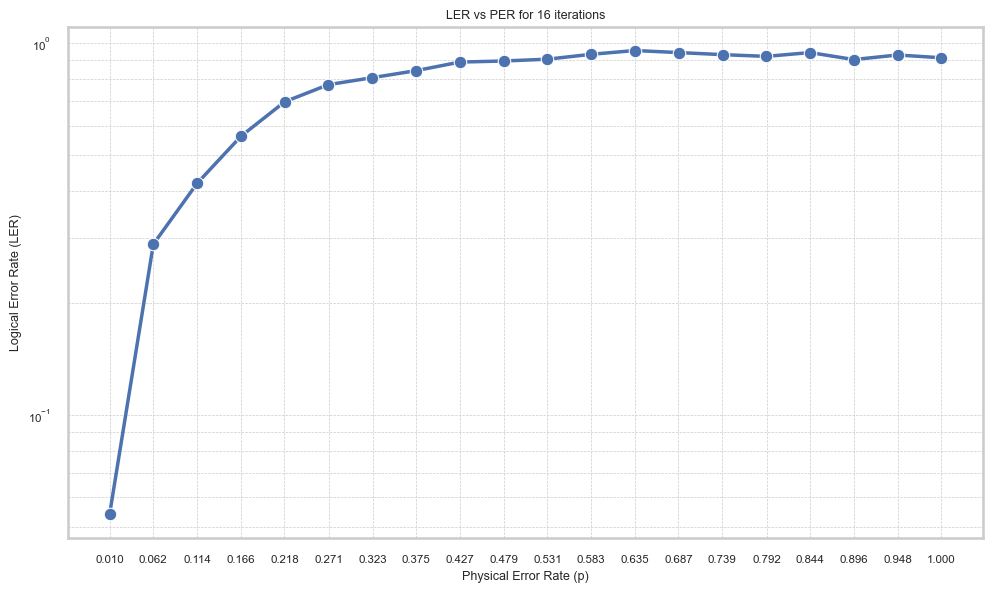

In [23]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=16,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


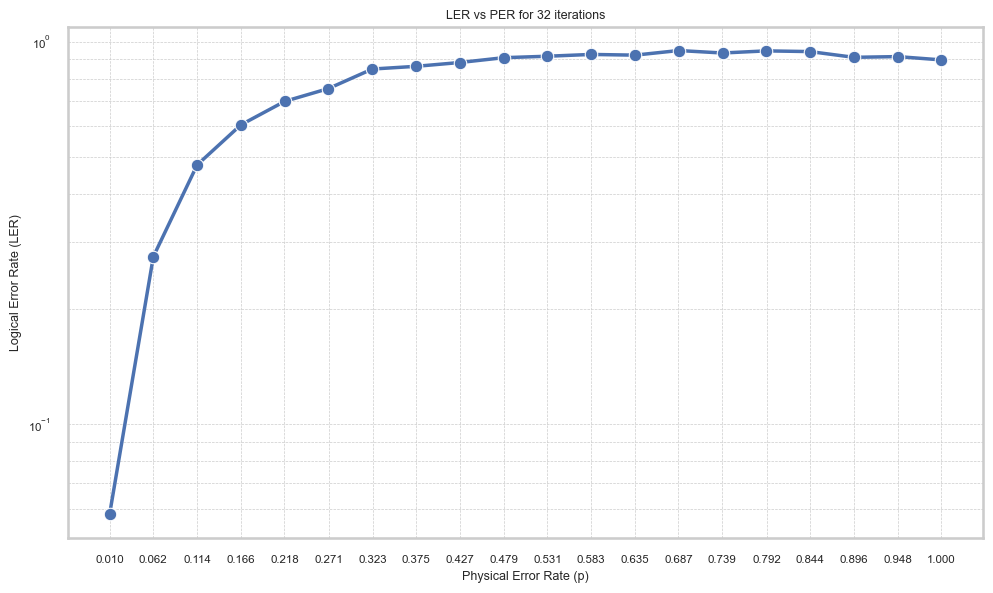

In [24]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=32,  N_trials=500)

Simulating for p = 0.010
Simulating for p = 0.062
Simulating for p = 0.114
Simulating for p = 0.166
Simulating for p = 0.218
Simulating for p = 0.271
Simulating for p = 0.323
Simulating for p = 0.375
Simulating for p = 0.427
Simulating for p = 0.479
Simulating for p = 0.531
Simulating for p = 0.583
Simulating for p = 0.635
Simulating for p = 0.687
Simulating for p = 0.739
Simulating for p = 0.792
Simulating for p = 0.844
Simulating for p = 0.896
Simulating for p = 0.948
Simulating for p = 1.000


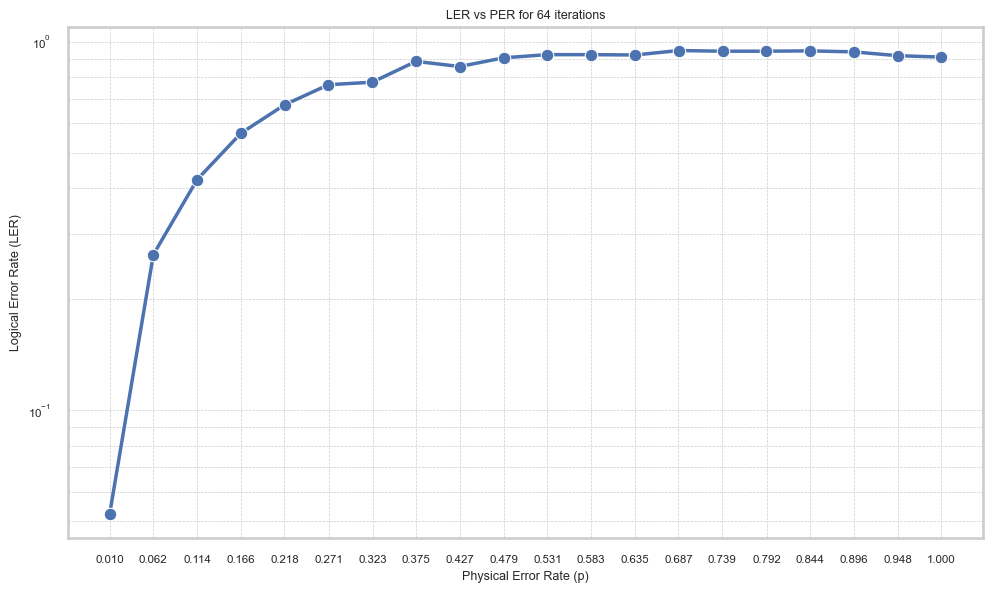

In [25]:
plot_logical_error_rate(HX, HZ, decoder_fn=decoder, max_iter=64,  N_trials=500)

In [29]:
def plot_logical_error_rate_multi(Hx, Hz, decoder_fn, max_iter_list, N_trials=100, p_range=None):
    """
    Plot LER vs PER for multiple max_iter values on a single figure.
    Each curve has a different color and no markers.
    """
    if p_range is None:
        p_range = np.linspace(0.01, 1.0, 10)

    sns.set(style="whitegrid", context="talk", font_scale=0.8)
    palette = sns.color_palette("husl", len(max_iter_list))
    plt.figure(figsize=(20, 12))

    for idx, max_iter in enumerate(max_iter_list):
        logical_error_rates = []
        print(f"\n--- max_iter = {max_iter} ---")
        for p in p_range:
            print(f"Simulating for p = {p:.3f}")
            ler = simulation(Hx, Hz, decoder_fn, p, N_trials, max_iter)
            logical_error_rates.append(ler)
        plt.plot(p_range, logical_error_rates, label=f"max_iter={max_iter}", color=palette[idx], linewidth=2.5)

    plt.title("LER vs PER for different decoder max_iter")
    plt.xlabel("Physical Error Rate (p)")
    plt.ylabel("Logical Error Rate (LER)")
    plt.yscale("log")
    plt.xticks(np.round(p_range, 3))
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.legend(title="Decoder Iterations")
    plt.tight_layout()
    plt.show()


--- max_iter = 1 ---
Simulating for p = 0.010
Simulating for p = 0.120
Simulating for p = 0.230
Simulating for p = 0.340
Simulating for p = 0.450
Simulating for p = 0.560
Simulating for p = 0.670
Simulating for p = 0.780
Simulating for p = 0.890
Simulating for p = 1.000

--- max_iter = 2 ---
Simulating for p = 0.010
Simulating for p = 0.120
Simulating for p = 0.230
Simulating for p = 0.340
Simulating for p = 0.450
Simulating for p = 0.560
Simulating for p = 0.670
Simulating for p = 0.780
Simulating for p = 0.890
Simulating for p = 1.000

--- max_iter = 4 ---
Simulating for p = 0.010
Simulating for p = 0.120
Simulating for p = 0.230
Simulating for p = 0.340
Simulating for p = 0.450
Simulating for p = 0.560
Simulating for p = 0.670
Simulating for p = 0.780
Simulating for p = 0.890
Simulating for p = 1.000

--- max_iter = 8 ---
Simulating for p = 0.010
Simulating for p = 0.120
Simulating for p = 0.230
Simulating for p = 0.340
Simulating for p = 0.450
Simulating for p = 0.560
Simulating f

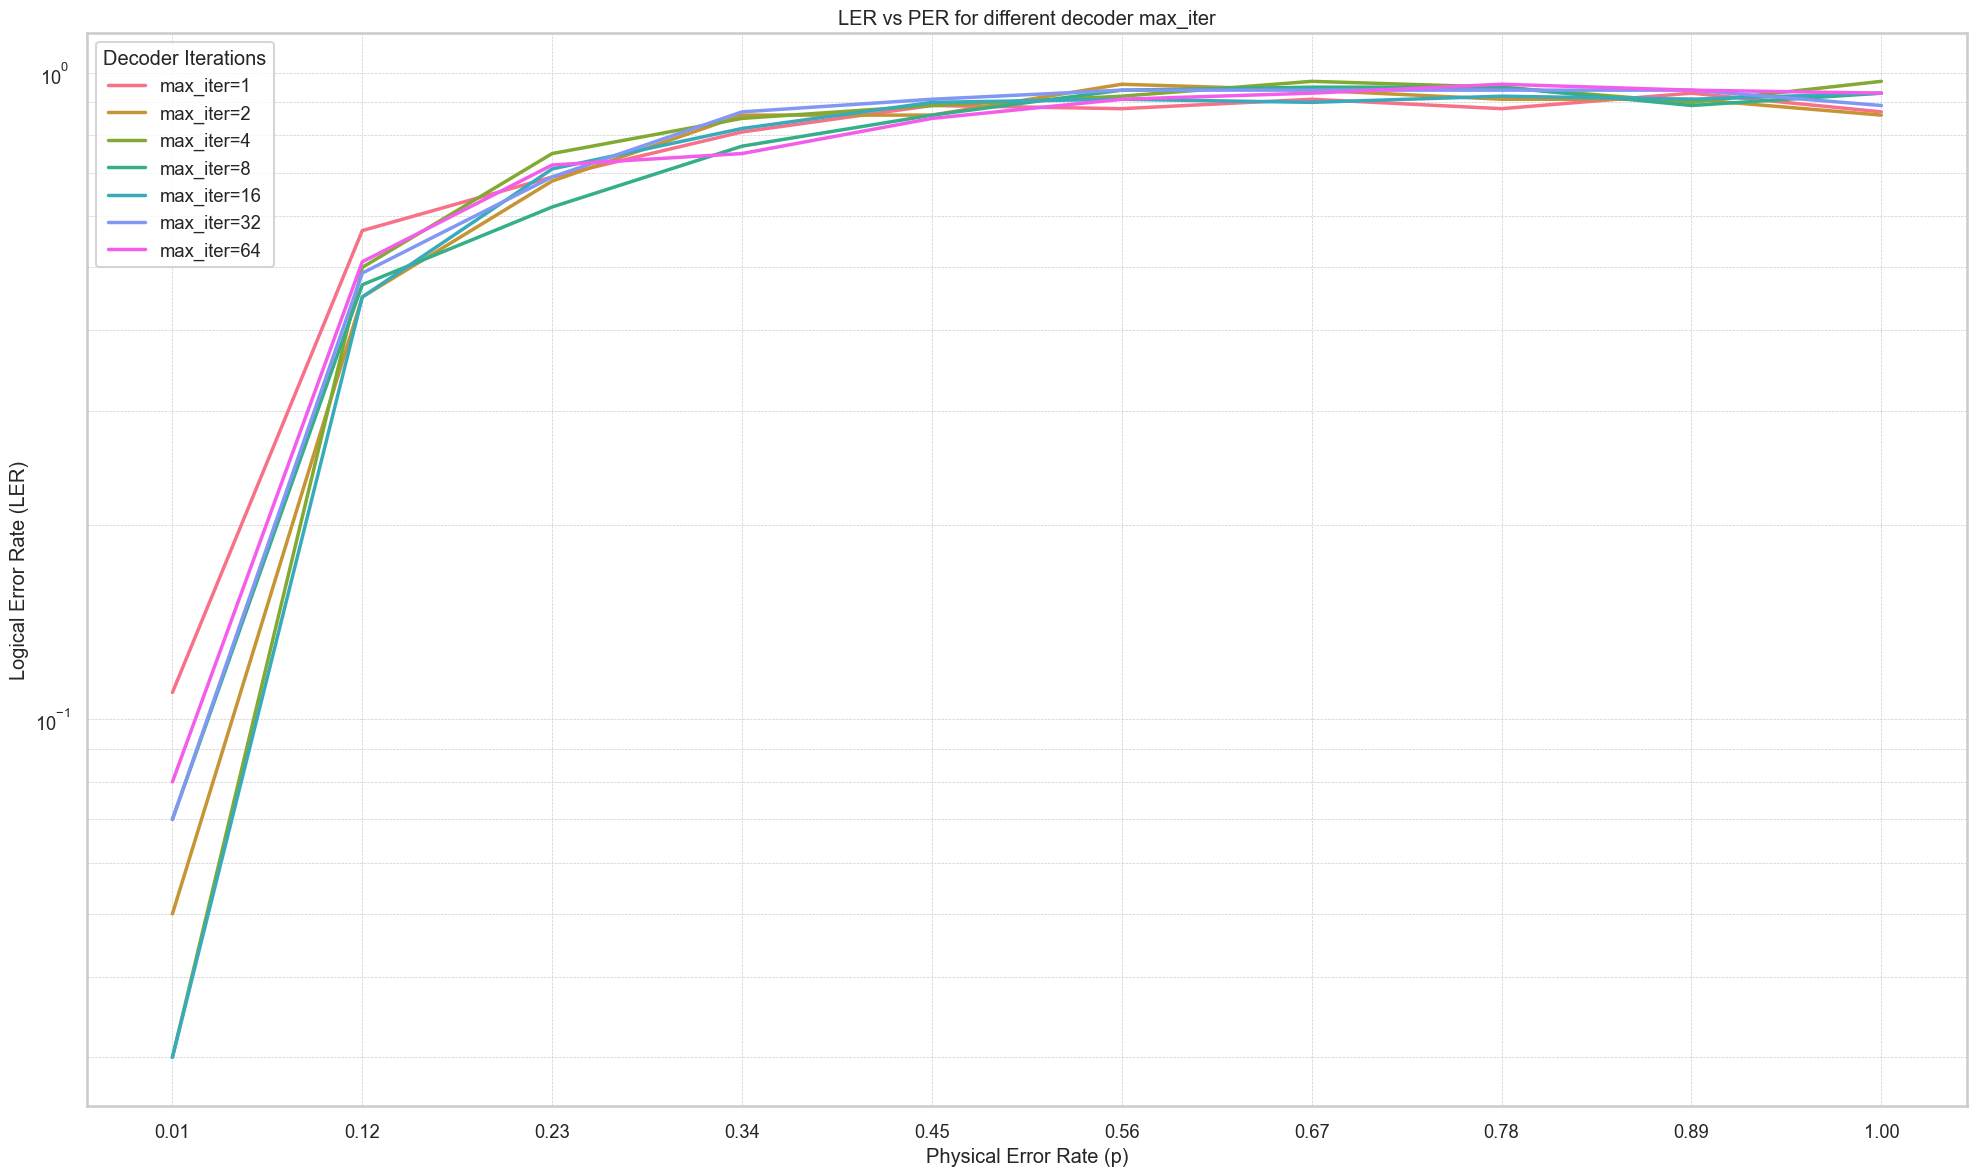

In [30]:
plot_logical_error_rate_multi(HX, HZ, decoder_fn=decoder, max_iter_list=[1, 2, 4, 8, 16, 32, 64], N_trials=100)